# Multi-resolution deconvolution of spatial transcriptomics

In this tutorial, we through the steps of applying DestVI for deconvolution of 10x Visium spatial transcriptomics profiles using an accompanying single-cell RNA sequencing data. 

Plan for this tutorial:

1. Loading the data
2. Training the scLVM to learn a basis of gene expression on the scRNA-seq data
3. Training the stLVM to perform the deconvolution
4. Visualize the learned cell type proportions
5. Dig into the intra cell type information 

In [1]:
# For now scanpy==1.9.1 leads to matplotlib update and makes restart of runtime necessary, installing scanpy==1.8.2 manually for now.
!pip install --quiet scanpy==1.8.2
!pip install --quiet scvi-colab
from scvi_colab import install
install(branch='master')
!pip install --quiet git+https://github.com/yoseflab/destvi_utils.git@main

Let's download our data from a comparative study of murine lymph nodes, comparing wild-type with a stimulation after injection of a mycobacteria. We have at disposal a 10x Visium dataset as well as a matching scRNA-seq dataset from the same tissue.

In [2]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

from scvi.model import CondSCVI, DestVI

sc.set_figure_params(figsize=(4, 4), frameon=False)

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [3]:
url1 = "https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/ST-LN-compressed.h5ad?raw=true"
url2 = "https://github.com/romain-lopez/DestVI-reproducibility/blob/master/lymph_node/deconvolution/scRNA-LN-compressed.h5ad?raw=true"
out1 = "data/ST-LN-compressed.h5ad"
out2 = "data/scRNA-LN-compressed.h5ad"

## Data processing

First, let's load the single-cell data

In [4]:
sc_adata = sc.read(out2, backup_url=url2)

  0%|          | 0.00/76.0M [00:00<?, ?B/s]

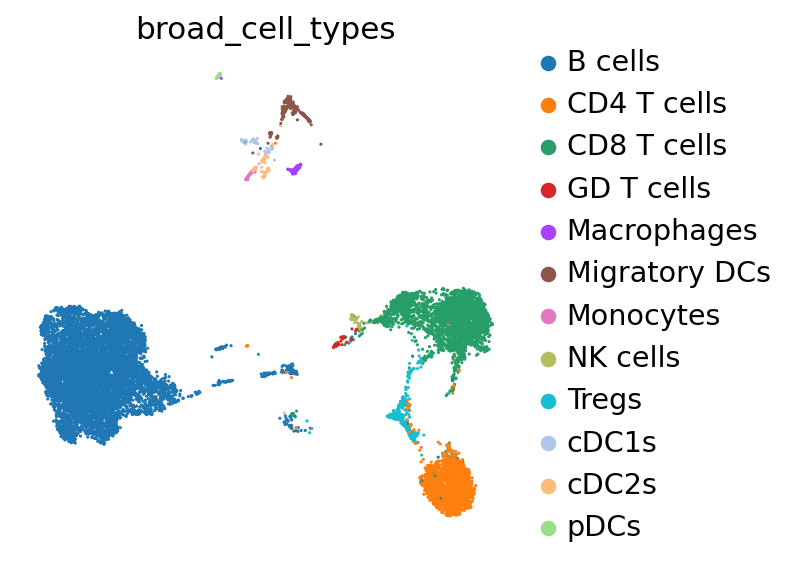

In [5]:
sc.pl.umap(sc_adata, color="broad_cell_types")

In [6]:
# let us filter some genes
G = 2000
sc.pp.filter_genes(sc_adata, min_counts=10)

sc_adata.layers["counts"] = sc_adata.X.copy()

sc.pp.highly_variable_genes(
    sc_adata,
    n_top_genes=G,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

sc.pp.normalize_total(sc_adata, target_sum=10e4)
sc.pp.log1p(sc_adata)
sc_adata.raw = sc_adata

Now, let's load the spatial data and choose a common gene subset

In [7]:
st_adata = sc.read(out1, backup_url=url1)

  0%|          | 0.00/12.8M [00:00<?, ?B/s]

In [8]:
st_adata.layers["counts"] = st_adata.X.copy()
st_adata.obsm['spatial'] = st_adata.obsm['location']

sc.pp.normalize_total(st_adata, target_sum=10e4)
sc.pp.log1p(st_adata)
st_adata.raw = st_adata

In [9]:
# filter genes to be the same on the spatial data
intersect = np.intersect1d(sc_adata.var_names, st_adata.var_names)
st_adata = st_adata[:, intersect].copy()
sc_adata = sc_adata[:, intersect].copy()
G = len(intersect)

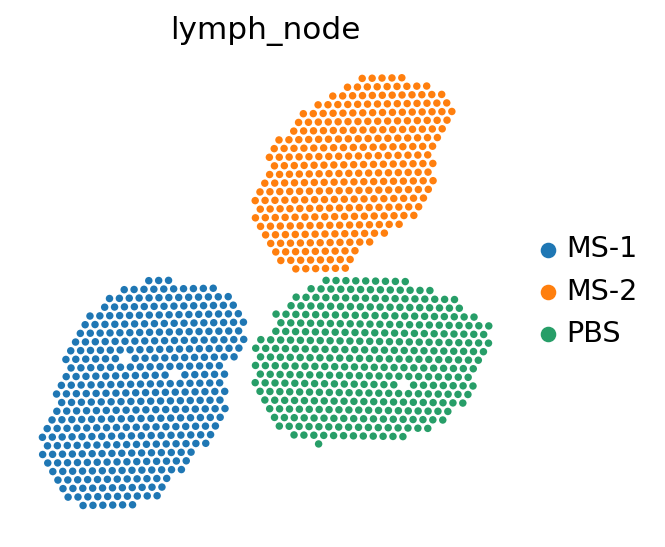

In [10]:
sc.pl.spatial(st_adata, color="lymph_node", spot_size=130)

## Fit the scLVM

In [11]:
CondSCVI.setup_anndata(sc_adata, layer="counts", labels_key="broad_cell_types")

As a first step, we embed our data using a cell type conditional VAE. We pass the layer containing the raw counts and the labels key. We train this model without reweighting the loss by the cell type abundance. Training will take around 5 minutes in a Colab GPU session.


In [12]:
sc_model = CondSCVI(sc_adata, weight_obs=False)
sc_model.view_anndata_setup()

In [13]:
sc_model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 300/300: 100%|██████████| 300/300 [05:45<00:00,  1.15s/it, loss=814, v_num=1]


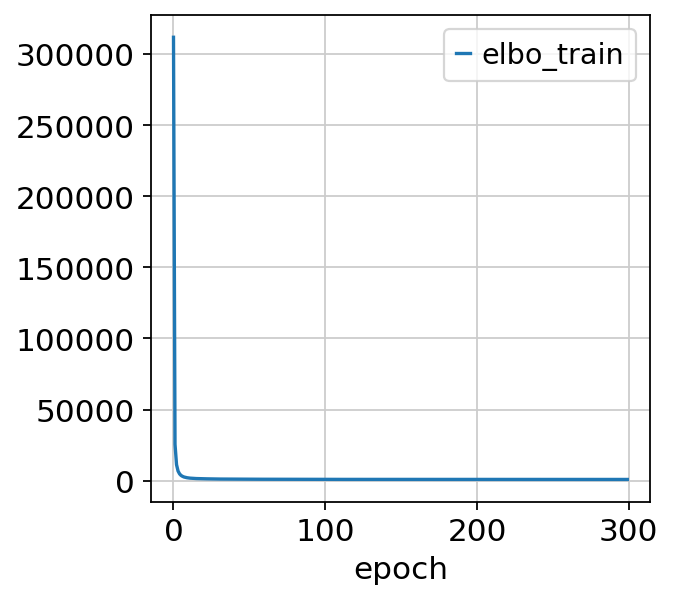

In [14]:
sc_model.history["elbo_train"].plot()

Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and performance deteriorates as max_epochs<200.

## Deconvolution with stLVM

As a second step, we train our deconvolution model stLVM.
We setup the DestVI model using the layer in st_adata containing the raw counts. Potential adaptations of DestVI.from_rna_model are increasing vamp_prior_p leads to less gradual changyes in gamma values and more discretized values. Increasing l1_sparsity will lead to sparser results for cell type proportions. We recommend using similar sequencing technology for both assays. Using different technologies might benefit in changes of beta_weighting_prior.


We pass the trained CondSCVI model and generate a new model based on st_adata and sc_model. The decoder network architecture will be generated from sc_model. Two neural networks are initiated for cell type proportions and gamma value amortization. Training will take around 5 minutes in a Colab GPU session.

An adapted vamp_prior loss is used to enforce gamma values in stLVM match scLVM (see details in original publication). For computation we use a cell type specific subclustering using empirical mean and variance of these subclusters. By default p kmeans subclusters are computed. To enforce the gamma values to match preexpected subclusters user provided subclustering stored in .obs['overclustering_vamp'] will be used for cell type specific subclustering.

In [15]:
DestVI.setup_anndata(st_adata, layer="counts")

In [16]:
st_model = DestVI.from_rna_model(st_adata, sc_model)
st_model.view_anndata_setup()

In [17]:
st_model.train(max_epochs=2500)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/data_loading.py:433: UserWarning: The number of training samples (9) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  f"The number of training samples ({self.num_training_batches}) is smaller than the logging interval"


Epoch 2500/2500: 100%|██████████| 2500/2500 [04:50<00:00,  8.62it/s, loss=1.95e+06, v_num=1]


Note that model converges quickly. Over experimentation with the model drastically reducing the number of epochs leads to decreased performance and we advocate against max_epochs<1000.

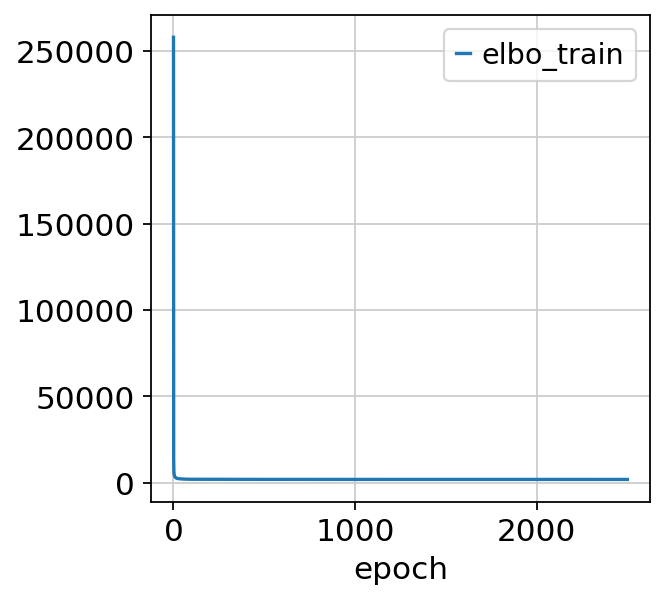

In [18]:
st_model.history["elbo_train"].plot()

The output of DestVI has two resolution. At the broader resolution, DestVI returns the cell type proportion in every spot. At the more granular resolution, DestVI can impute cell type specific gene expression in every spot. 

## Cell type proportions


We extract the computed cell type proportions and display them in spatial embedding. Cell type proportion values are not sparse and using cells with lower proportion values leads to wrong intrepretation of expression values. Therefore, we use infliction points of the cumulative distribution to find appropriate automatic threshold values. For follow-up analysis we recommend checking these threshold values and adjust them for each cell type.

In [19]:
st_adata.obsm["proportions"] = st_model.get_proportions()

In [20]:
st_adata.obsm["proportions"]

,B cells,CD4 T cells,CD8 T cells,GD T cells,Macrophages,Migratory DCs,Monocytes,NK cells,Tregs,cDC1s,cDC2s,pDCs
AAACCGGGTAGGTACC-1-0,0.642821,0.009133,0.048631,0.001883,0.028526,0.028299,0.041506,0.068736,0.042653,0.056685,0.012831,0.018297
AAACCTCATGAAGTTG-1-0,0.599079,0.024904,0.073012,0.007396,0.022820,0.053057,0.055390,0.064917,0.025092,0.026119,0.037690,0.010524
AAAGACTGGGCGCTTT-1-0,0.553710,0.024247,0.098830,0.004738,0.020433,0.077447,0.031703,0.074599,0.029511,0.047068,0.036233,0.001481
AAAGGGCAGCTTGAAT-1-0,0.079860,0.135610,0.347425,0.003620,0.009415,0.097961,0.037403,0.065563,0.139114,0.052310,0.029629,0.002090
AAAGTCGACCCTCAGT-1-0,0.774980,0.018126,0.010346,0.002952,0.020493,0.030376,0.027595,0.029145,0.014909,0.037448,0.029934,0.003698
...,...,...,...,...,...,...,...,...,...,...,...,...
TTGGTCACACTCGTAA-1-1,0.385426,0.080139,0.184452,0.060620,0.006974,0.061502,0.069777,0.021482,0.072449,0.033709,0.018270,0.005200
TTGTAAGGCCAGTTGG-1-1,0.394452,0.027531,0.166497,0.018878,0.018627,0.046039,0.114248,0.030924,0.021883,0.057693,0.063830,0.039398
TTGTAATCCGTACTCG-1-1,0.634524,0.069736,0.028163,0.001453,0.030725,0.068474,0.033983,0.051235,0.016796,0.034953,0.026943,0.003014
TTGTATCACACAGAAT-1-1,0.363003,0.117850,0.147347,0.005915,0.019277,0.140794,0.039940,0.026079,0.051005,0.021864,0.064459,0.002465


In [21]:
ct_list = ["B cells", "CD8 T cells", "Monocytes"]
for ct in ct_list:
  data = st_adata.obsm["proportions"][ct].values
  st_adata.obs[ct] = np.clip(data, 0, np.quantile(data, 0.99))

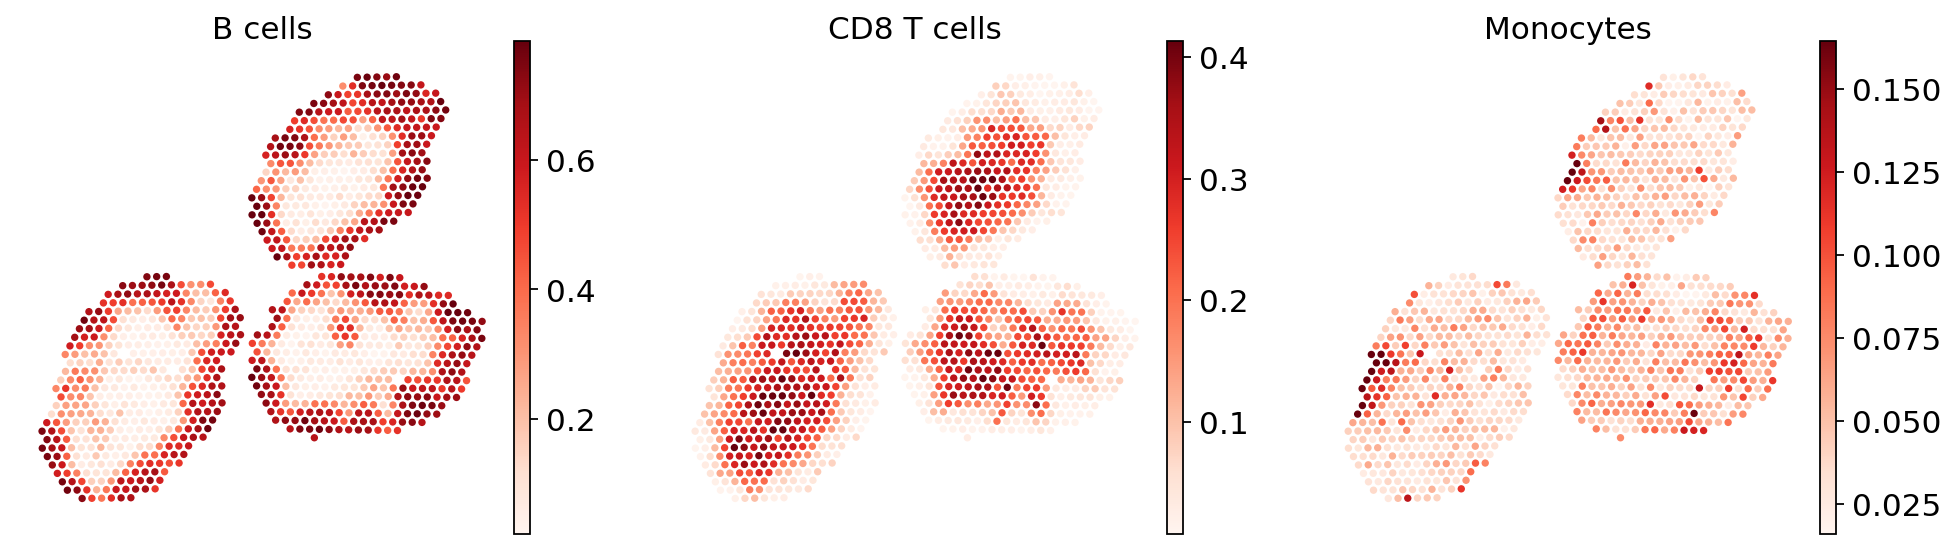

In [22]:
sc.pl.spatial(st_adata, color=ct_list, cmap='Reds', spot_size=130)

In [23]:
import destvi_utils

Creating directory /root/.config/bioservices 


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
100%|██████████| 100/100 [00:00<00:00, 233.95it/s]


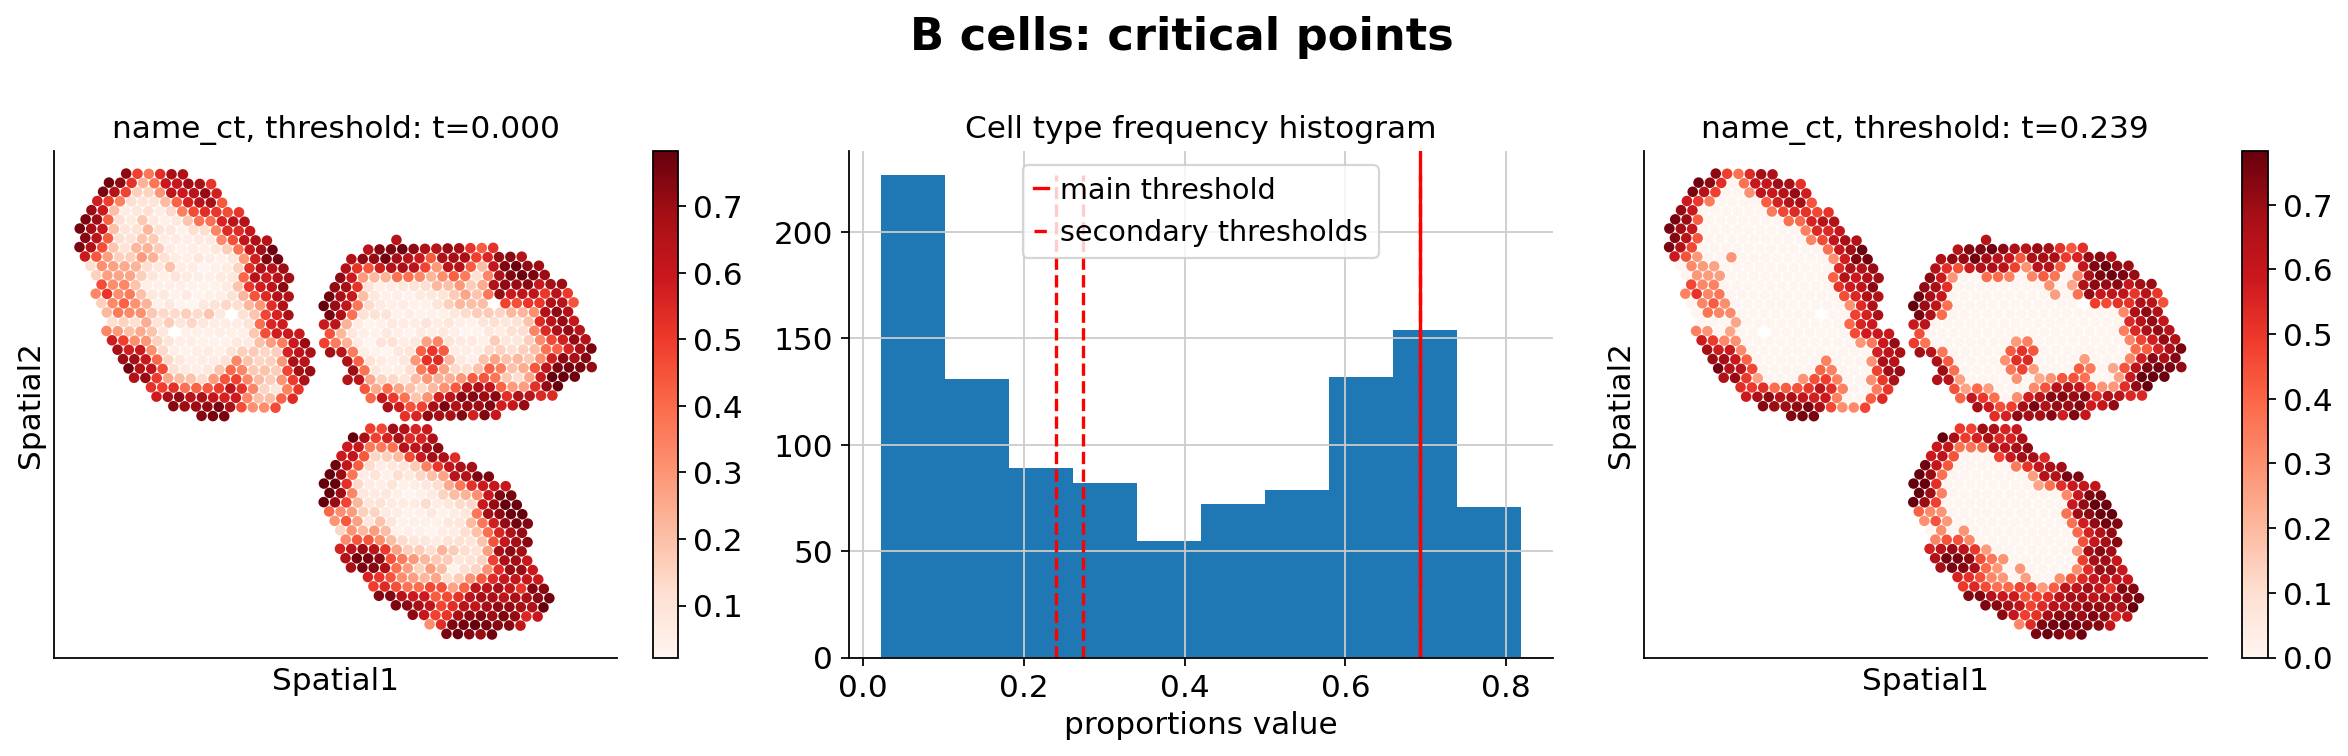

100%|██████████| 100/100 [00:00<00:00, 12242.93it/s]


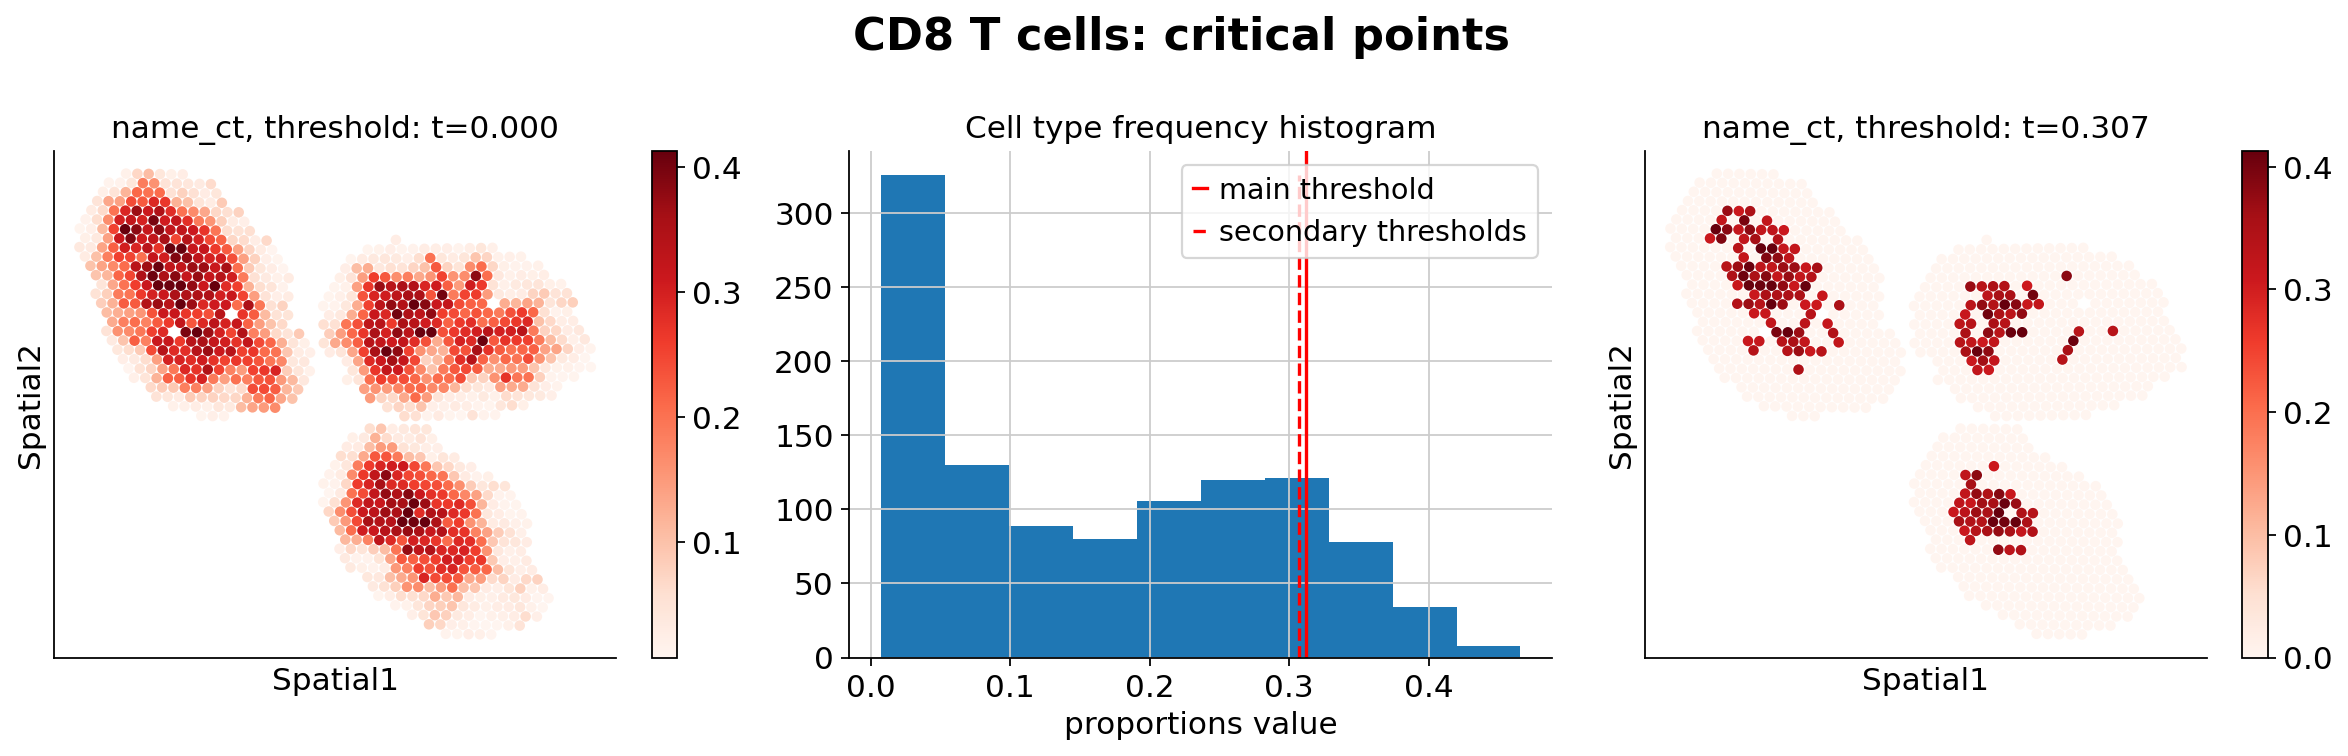

100%|██████████| 100/100 [00:00<00:00, 6667.26it/s]


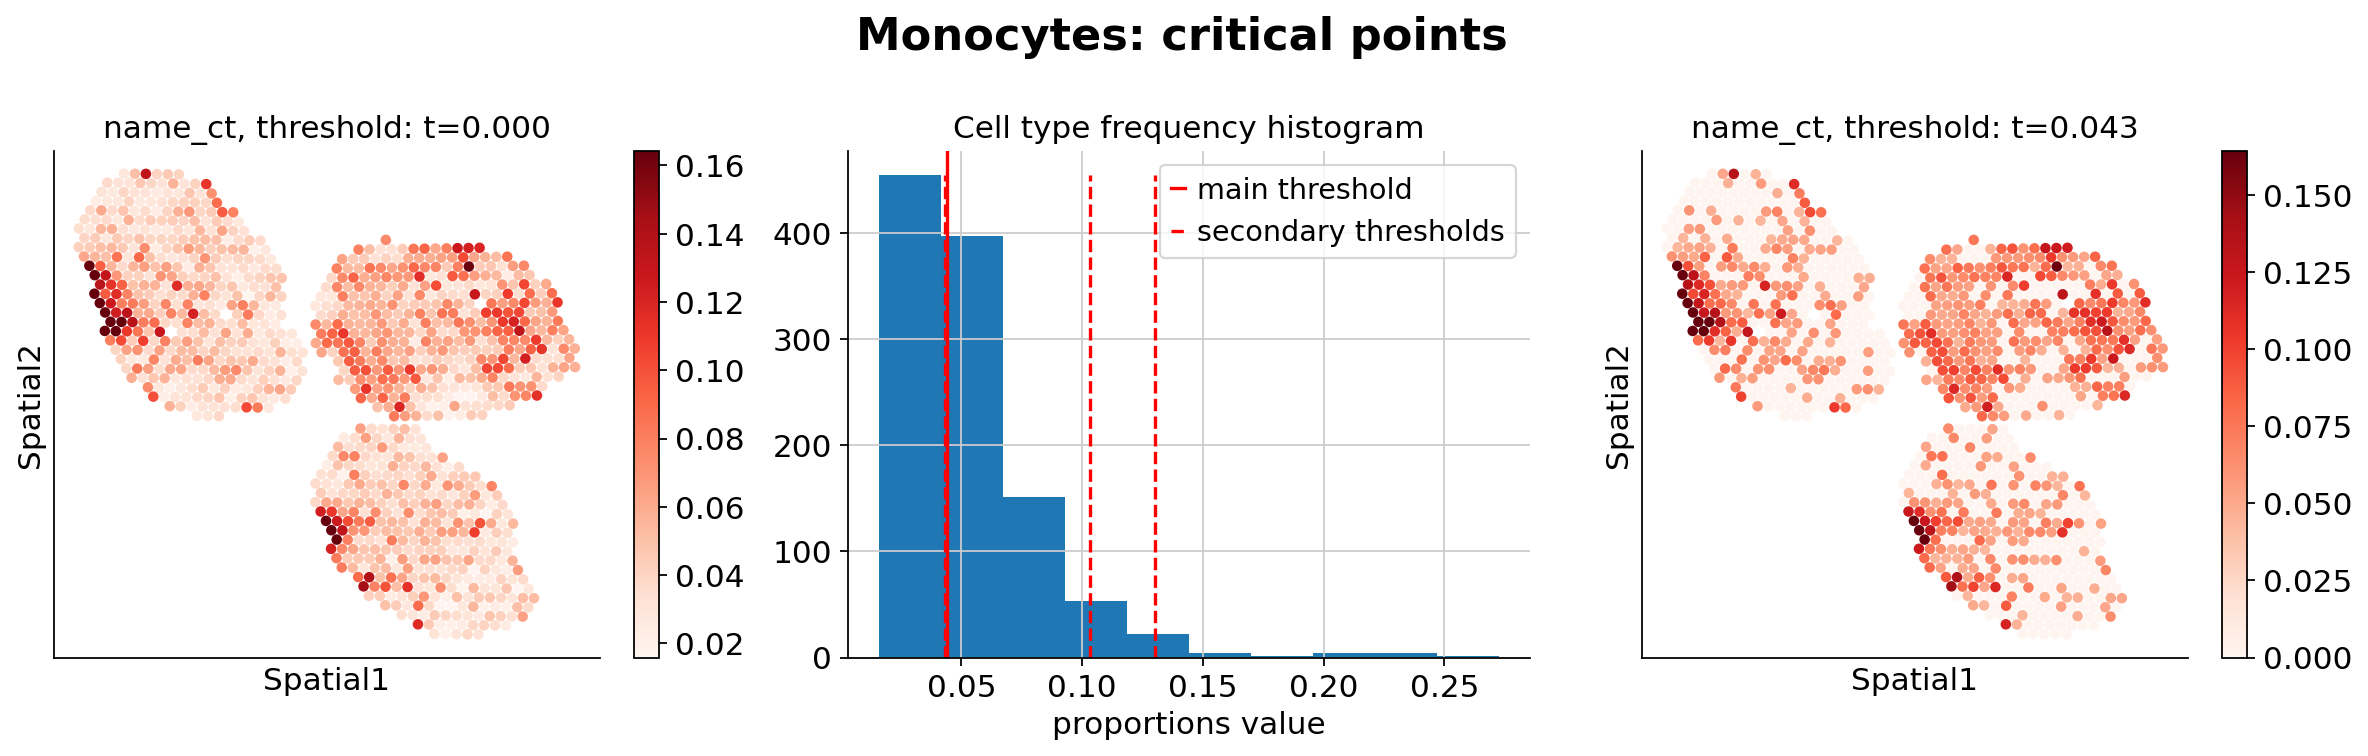

In [24]:
ct_thresholds = destvi_utils.automatic_proportion_threshold(st_adata, ct_list=ct_list, kind_threshold='secondary')

We observe a strong compartimentalization of the cell types in the lymph node (B cells / T cells), as expected. We also observe a differential localization of the monocytes (refer to the paper for further details).

## Intra cell type information

At the heart of DestVI is a multitude of latent variables (5 per cell type per spots). We refer to them as "gamma", and we may manually examine them for downstream analysis

In [25]:
# more globally, the values of the gamma are all summarized in this dictionary of data frames
for ct, g in st_model.get_gamma().items():
  st_adata.obsm["{}_gamma".format(ct)] = g

In [26]:
st_adata.obsm["B cells_gamma"].head(5)

,0,1,2,3,4
AAACCGGGTAGGTACC-1-0,0.027521,-0.526543,0.491092,-0.180955,0.300883
AAACCTCATGAAGTTG-1-0,-0.601435,-0.306528,-2.216609,-0.012317,0.413721
AAAGACTGGGCGCTTT-1-0,-1.254444,-0.088996,-1.609583,0.299078,0.915245
AAAGGGCAGCTTGAAT-1-0,-0.082905,-0.035406,2.039065,0.107000,0.499636
AAAGTCGACCCTCAGT-1-0,0.350596,-0.700346,-0.607777,0.057218,-0.230876


Because those values may be hard to examine manually for end-users, we presented several methods for prioritizing the study of different cell types (based on PCA and Hotspot). Below we display the methods we developed to examine those values. If you have suggestions to improve those, and would like to see them in the main codebase, reach out to us. 

For de novo detection of spatial patterns we study the gamma space and use embedding to spatially informed PCA to find spatial axis of variation in the data. We use enrichr to functionally annotate these genes and find here that IFN module is spatially varying in the lymph nodes

In [ ]:
destvi_utils.explore_gamma_space(st_model, sc_model, ct_list=ct_list, ct_thresholds=ct_thresholds)

# DE for Bcells

Based on this by using a Kolmogorov-Smirnov test on generated counts, we study the differential expression within B cells between lymph nodes with tuberculosis vs without tuberculosis. We display the identified IFN genes in a Volcano plot and see significant upregulation in the diseased lymph nodes.

In [ ]:
plt.figure(figsize=(8, 8))

ct_name = "B cells"
gene_name = ["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"]

# we must filter spots with low abundance (consult the paper for an automatic procedure)
indices = np.where(st_adata.obsm["proportions"][ct_name].values > 0.2)[0]

# impute genes and combine them
specific_expression = np.sum(st_model.get_scale_for_ct(ct_name, indices=indices)[gene_name], 1)
specific_expression = np.log(1 + 1e4 * specific_expression)

# plot (i) background (ii) g
plt.scatter(st_adata.obsm["location"][:, 0], st_adata.obsm["location"][:, 1], alpha=0.05)
plt.scatter(st_adata.obsm["location"][indices][:, 0], st_adata.obsm["location"][indices][:, 1], 
            c=specific_expression, s=10, cmap="Reds")
plt.colorbar()
plt.title(f"Imputation of {gene_name} in {ct_name}")
plt.show()

In [ ]:
ct = 'B cells'
_ = destvi_utils.de_genes(
    st_model, mask=np.logical_or(st_adata.obs['LN'] == "TC", st_adata.obs['LN'] == "BD").values,
    threshold=0.2, ct=ct, key='disease')

display(st_adata.uns['disease']['de_results'].head(10))

destvi_utils.plot_de_genes(
    st_adata, key='disease', 
    interesting_genes=["Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"])

In [ ]:
imputation = st_model.get_scale_for_ct(ct)
color = np.log(1 + 1e5 * imputation["Ifit3"].values)
threshold = 4

mask = np.logical_and(
    np.logical_or(st_adata.obs['LN'] == "TC", st_adata.obs['LN'] == "BD"),
    color > threshold).values

mask2 = np.logical_and(
    np.logical_or(st_adata.obs['LN'] == "TC", st_adata.obs['LN'] == "BD"),
    color < threshold).values

In [ ]:
_ = destvi_utils.de_genes(
    st_model, mask=mask, mask2=mask2, threshold=ct_thresholds[ct], ct=ct, key='IFN_rich')

display(st_adata.uns['IFN_rich']['de_results'].head(10))

destvi_utils.plot_de_genes(st_adata, interesting_genes=[
  "Ifit3", "Ifit3b", "Ifit1", "Isg15", "Oas3", "Usp18", "Isg20"], key='IFN_rich')